In [1]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

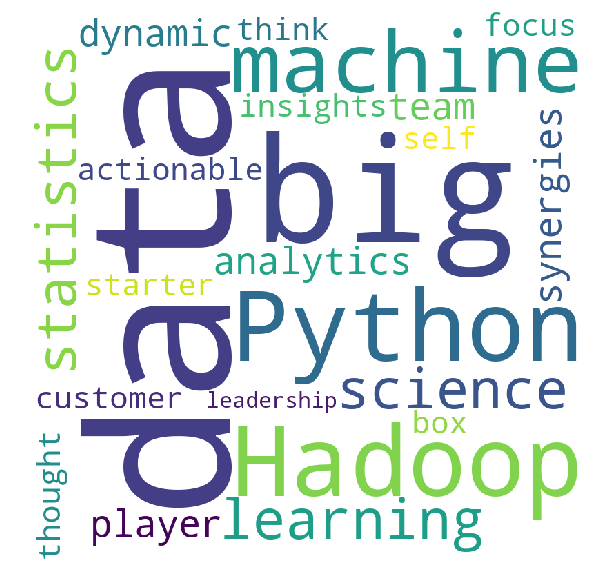

In [16]:
# How to creat a word cloud?

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

stopwords = set(STOPWORDS) 

words = [t[0] for t in data]

# convert the list of words into a combined string
comment_words = ' '
for word in words:
    comment_words = comment_words + word + ' '

# create the word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   

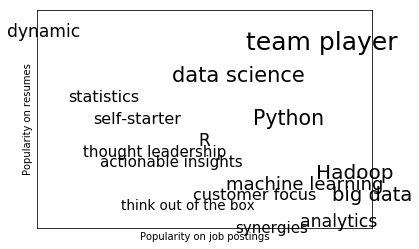

In [14]:
def text_size(total: int) -> float:
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total/ 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
            ha = 'center', va = 'center',
            size = text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on job postings")
plt.ylabel("Popularity on resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

In [32]:
# replace Unicode apostrophies in text with normal apostrophies
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019","'")

# split the text into a sequence of words and periods 
# (so that we know where the sentence ends)

import re
from bs4 import BeautifulSoup
import requests

# get the text from a particular url
url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

# find post-radar-content div
content = soup.find("div", "post-radar-content") 
regex = r"[\w']+|[\.]" # matches a word or a period

document = []

# find unique words in each paragraph
for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

In [37]:
from collections import defaultdict
transitions =  defaultdict(list)

for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

In [40]:
def generate_using_bigrams() -> str:
    current = "." # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates =  transitions[current] # bigrams(current, _)
        current = random.choice(next_word_candidates) # choose one at random
        result.append(current) # append it to results
        if current == ".": return " ".join(result) # If "." we are done

In [43]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):
    if prev == ".": # if previous word was period
        starts.append(current) # then this is a start word
        
    trigram_transitions[(prev, current)].append(next)
    
def generate_using_trigrams() -> str:
    current = random.choice(starts) # choose a random starting word
    prev = "." # and precede it with a period
    result = [current]
    
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        
        prev, current = current, next_word
        result.append(current)
        
        if current == ".":
            return " ".join(result)

In [46]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

# generate sentences
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

In [51]:
# Gibbs Sampling

from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)
    
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
       s y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [9]:
# Topic modeling
import random
from typing import List
from collections import Counter

def sample_from(weights: List[float]) -> int:
    """Returns i with probability weights[i]/sum(weights)"""
    total = sum(weights)
    rnd = total * random.random() # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w   # return the smallest i such that
        if rnd <= 0: return i # weight[0] +...+ weights[i] >= rnd
        
# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))

print(f"draws[0] = {draws[0]}")
print(f"draws[1] = {draws[1]}")
print(f"draws[2] = {draws[2]}")

draws[0] = 97
draws[1] = 113
draws[2] = 790


In [10]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]


In [61]:
K = 4

# How many times each topic is assigned to each document
# a list of counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# How many times each word is assigned to each topic
# a list of counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# The total number of words assigned to each topic
# a list of numbers one for each topic
topic_counts = [0 for _ in range(K)]

# The total number of words in each document
# a list of numbers, ones for each document
document_lengths = [len(documents) for document in documents]

# The number of distinct words
distinc_words = set(word for document in documents for word in document)

# The number of documents
D = len(documents)

In [90]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """The fraction of words in document 'd' that are assigned to 'topic'(+ some smoothing)"""
    return (document_topic_counts[d][topic] + alpha)/(document_lengths[d] + K*alpha)

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """The fraction of words assigned to 'topic' that equals word (+ some smoothing)"""
    return (topic_word_counts[topic][word] + beta)/(topic_counts[topic] + K*beta)

def topic_weight(d: int, word: str, k: int) -> float:
    """Given a document and a word in that document, return the weight for the kth topic"""
    return p_word_given_topic(word, k)*p_topic_given_document(k,d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k) for k in range(K)])


In [91]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                  for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [100]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d], document_topics[d])):
            # remove this word/topic from the counts
            # so that it doesn't influence the weigts
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # choose new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic
            
            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1


100%|██████████| 1000/1000 [00:00<00:00, 1548.54it/s]


In [102]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0: 
            print(k, word, count)

0 statistics -1990
0 Java -1991
0 R -1992
0 C++ -1992
0 Haskell -1992
0 artificial intelligence -1992
0 Hadoop -1992
0 statsmodels -1992
0 HBase -1993
0 regression -1993
0 Big Data -1993
0 libsvm -1993
0 scikit-learn -3984
0 pandas -3984
1 Postgres -1991
1 MongoDB -1991
1 Cassandra -1992
1 HBase -1992
1 Python -1992
1 numpy -1992
1 decision trees -1992
1 theory -1992
1 Mahout -1992
1 databases -1992
1 MySQL -1992
1 neural networks -3984
1 deep learning -3984
2 probability -1991
2 HBase -1991
2 Cassandra -1992
2 scipy -1992
2 statsmodels -1992
2 mathematics -1992
2 machine learning -1992
2 C++ -1992
2 artificial intelligence -1992
2 MongoDB -1993
2 Postgres -1993
2 statistics -1993
2 Python -3983
2 regression -3983
2 R -3983
2 Java -3985
3 libsvm -1991
3 Spark -1992
3 Storm -1992
3 NoSQL -1992
3 machine learning -1992
3 programming languages -1992
3 MapReduce -1992
3 support vector machines -1992
3 statistics -1993
3 Python -1993
3 R -1993
3 Hadoop -2001
3 Big Data -3983
3 probability -

In [103]:
topic_word_counts

[Counter({'HBase': -1993,
          'scikit-learn': -3984,
          'pandas': -3984,
          'R': -1992,
          'regression': -1993,
          'Java': -1991,
          'C++': -1992,
          'Haskell': -1992,
          'statistics': -1990,
          'artificial intelligence': -1992,
          'Hadoop': -1992,
          'Big Data': -1993,
          'statsmodels': -1992,
          'libsvm': -1993}),
 Counter({'Cassandra': -1992,
          'HBase': -1992,
          'Python': -1992,
          'numpy': -1992,
          'decision trees': -1992,
          'theory': -1992,
          'Mahout': -1992,
          'neural networks': -3984,
          'deep learning': -3984,
          'databases': -1992,
          'Postgres': -1991,
          'MySQL': -1992,
          'MongoDB': -1991}),
 Counter({'Java': -3985,
          'Cassandra': -1992,
          'MongoDB': -1993,
          'Postgres': -1993,
          'scipy': -1992,
          'statsmodels': -1992,
          'Python': -3983,
          'p

In [104]:
topic_names = ["Big data and programming languages",
              "Python and statistics",
              "databases",
              "machine learning"]

In [108]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big data and programming languages -1993
databases -3983
machine learning -7977
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
machine learning -1992
Python and statistics -3983
databases -3985
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Big data and programming languages -3983
Python and statistics -3984
databases -3985
['R', 'Python', 'statistics', 'regression', 'probability']
machine learning -1993
databases -3982
Big data and programming languages -3985
['machine learning', 'regression', 'decision trees', 'libsvm']
databases -1992
Python and statistics -1992
machine learning -3984
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases -1992
machine learning -3985
Big data and programming languages -5975
['statistics', 'probability', 'mathematics', 'theory']
databases -1991
Big data and programming languages -1992
Python and statistics -1992
machine learning

In [60]:
from vector_operations import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2)/math.sqrt(dot(v1,v1) * dot(v2,v2))

print(f"cosine_similarity([1.,1.,1.], [2.,2.,2.]) = {cosine_similarity([1.,1.,1.], [2.,2.,2.])}")
print(f"cosine_similarity([-1.,-1.], [2.,2.]) = {cosine_similarity([-1.,-1.], [2.,2.])}")
print(f"cosine_similarity([1.,0.], [0.,1.]) = {cosine_similarity([1.,0.], [0.,1.])}")

cosine_similarity([1.,1.,1.], [2.,2.,2.]) = 1.0
cosine_similarity([-1.,-1.], [2.,2.]) = -1.0
cosine_similarity([1.,0.], [0.,1.]) = 0.0


In [38]:
import random
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join(["The",
                    random.choice(colors),
                    random.choice(nouns),
                    random.choice(verbs),
                    random.choice(adverbs),
                    random.choice(adjectives),
                    "."])

NUM_SENTENCES = 50
random.seed(0)

sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

for sentence in sentences:
    print(sentence)

The yellow cat is extremely hard .
The yellow boat was extremely fast .
The black car was quite slow .
The black boat seems quite soft .
The red bed seems extremely hard .
The black bed was  soft .
The black car seems  hard .
The black boat is very slow .
The  cat seems very hard .
The blue car seems extremely slow .
The green car is quite hard .
The red bed was  slow .
The blue boat seems very soft .
The black car seems extremely hard .
The red cat was quite soft .
The green car is very soft .
The yellow bed is quite fast .
The red bed seems  soft .
The black car is  soft .
The yellow cat seems extremely slow .
The blue bed was extremely fast .
The green bed seems extremely slow .
The  car was quite soft .
The yellow bed is quite fast .
The red bed is very fast .
The black bed was very soft .
The red bed seems very fast .
The green bed was quite slow .
The  bed seems  slow .
The blue bed is very soft .
The blue cat is very hard .
The red bed seems  fast .
The blue boat seems  fast .
T

In [9]:
#from deep_learning import Tensor
Tensor = list
from typing import List
class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {} # mapping word to word_id
        self.i2w: Dict[int, str] = {} # mapping word_id to word
        
        for word in (words or []): # if words were provided
            self.add(word) # add them
            
    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)
        
    def add(self, word: str) -> None:
        if word not in self.w2i: # If the word is new to us:
            word_id = len(self.w2i) # Find the next id
            self.w2i[word] = word_id  # Add to the word -> word_id map
            self.i2w[word_id] = word # Add to the word_id -> map word 
                
    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)
        
    def get_word(self, word_id: int) -> str:
        return self.i2w.get(word_id)
        
    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unkown word {word}"
            
        return [1.0 if i == word_id else 0.0 for i in  range(self.size)]

In [20]:
vocab = Vocabulary(["a","b","c"])
print(f"vocab.size = {vocab.size}")
character = "b"
print(f"vocab.get_id(b) = {vocab.get_id(character)}")
print(f"vocab.one_hot_encode(b) = {vocab.one_hot_encode(character)}")
character = "z"
print(f"vocab.get_id(z) = {vocab.get_id(character)}")
vocab.add("z")
print(f"vocab.size = {vocab.size}")
print(f"vocab.get_id(z) = {vocab.get_id(character)}")
print(f"vocab.one_hot_encode(z) = {vocab.one_hot_encode(character)}")

vocab.size = 3
vocab.get_id(b) = 1
vocab.one_hot_encode(b) = [0.0, 1.0, 0.0]
vocab.get_id(z) = None
vocab.size = 4
vocab.get_id(z) = 3
vocab.one_hot_encode(z) = [0.0, 0.0, 0.0, 1.0]


In [23]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)  # Only need to save w2i
        
def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}

In [54]:
from typing import Iterable
from deep_learning import Layer, Tensor, random_tensor, zero_like

class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        
        # One vector of size embedding_dim for each desired embedding
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zero_like(self.embeddings)
        
        # save last input_id
        self.last_input_id = None
        
    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input_id"""
        self.input_id = input_id # remember for use in backpropagation
        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
    # Zero out the gradient corresponding to the last input.
    # This way cheaper than creating a new all-zero tensor each time.
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row
        
        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient
    
    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]
    
    def grads(self) -> Iterable[Tensor]:
        return [self.grad]
        

In [55]:
from typing import Tuple

class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructer
        super().__init__(vocab.size, embedding_dim)
        
        # And hang on to vocab
        self.vocab = vocab
        
    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None
        
    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Return n closest words based on cosine similarity"""
        vector = self(word)
        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)
        return scores[:n]

In [56]:
import re
    
    # This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                           for sentence in sentences]
    
# Create a vocabulary (that is, a mapping word -> word_id) based on our text.
vocab = Vocabulary(word
                       for sentence_words in tokenized_sentences
                       for word in sentence_words)
    
from deep_learning import Tensor

def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
        return [1.0 if j == i else 0.0 for j in range(num_labels)]
    
inputs: List[int] = []
targets: List[Tensor] = []
    
for sentence in tokenized_sentences:
        for i, word in enumerate(sentence):          # For each word
            for j in [i - 2, i - 1, i + 1, i + 2]:   # take the nearby locations
                if 0 <= j < len(sentence):           # that aren't out of bounds
                    nearby_word = sentence[j]        # and get those words.
    
                    # Add an input that's the original word_id
                    inputs.append(vocab.get_id(word))
    
                    # Add a target that's the one-hot-encoded nearby word
                    targets.append(vocab.one_hot_encode(nearby_word))

In [58]:
# Model for learning word vectors
    
from scratch.deep_learning import Sequential, Linear
    
random.seed(0)
EMBEDDING_DIM = 5  # seems like a good size
    
# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)
    
model = Sequential([
        # Given a word (as a vector of word_ids), look up its embedding.
        embedding,
        # And use a linear layer to compute scores for "nearby words".
        Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
    ])
    
    
# Train the word vector model
    
from scratch.deep_learning import SoftmaxCrossEntropy, Momentum, GradientDescent
    
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)
    
for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)            # Print the loss
    #print(embedding.closest("black"))   # and also a few nearest words
    #print(embedding.closest("slow"))    # so we can see what's being
    #print(embedding.closest("car"))     # learned.
    

0 2970.102142992442
1 2865.697690352553
2 2814.83595759849
3 2774.9006772309644
4 2740.4914640458005
5 2710.3306345780593
6 2683.705573761287
7 2660.1729760993226
8 2639.3818620947213
9 2620.9759979758064
10 2604.6007606512203
11 2589.9365720981277
12 2576.7157682842117
13 2564.722258955476
14 2553.7848737174936
15 2543.7707294958805
16 2534.5794209287037
17 2526.1368966572695
18 2518.3885044331696
19 2511.2917811102106
20 2504.8100209491085
21 2498.907446237876
22 2493.5463094928014
23 2488.6857905419724
24 2484.2822566328664
25 2480.2903524211424
26 2476.664436478841
27 2473.3600099737214
28 2470.334925037567
29 2467.550276422064
30 2464.9709599306957
31 2462.5659297047737
32 2460.308211904593
33 2458.174741185483
34 2456.1460835030894
35 2454.206098479344
36 2452.3415807909146
37 2450.541906104332
38 2448.7986952254714
39 2447.1055014908857
40 2445.457521218489
41 2443.851324844583
42 2442.2846064371206
43 2440.7559506753273
44 2439.2646182217454
45 2437.810351930019
46 2436.3932070

In [61]:
# Explore most similar words
    
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
             for w1 in vocab.w2i
             for w2 in vocab.w2i
             if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

[(0.9953034974983475, 'bed', 'cat'), (0.9920993073195691, 'seems', 'was'), (0.9899678630255155, 'bed', 'boat'), (0.9811517760817271, 'black', 'blue'), (0.9717835037022688, 'boat', 'cat')]


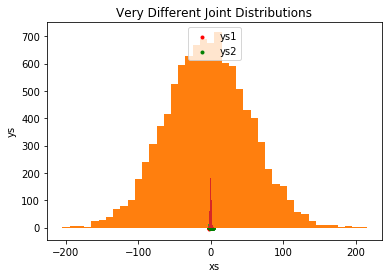

6.0
1
3
9
13
{1, 6}
99.0
81.54351395730716
9.03014473623248
6
22.425435139573064
0.24736957366478218
0.8933902141191054
-0.8963464131825052
[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]


  0%|          | 0/100 [00:00<?, ?it/s]

232.070007


168 primes: 100%|██████████| 997/997 [00:01<00:00, 698.03it/s]
dv: [1.5919452889207217, 0.11162039957636091, 36.4025547649421, 11.728489502502454, 6.3054693783325995, 409.1411976464874, 83.82938013669161, 0.5462659150557589, 4.768848492476459, 3.850536813148179, 263.53718173994434, 217.6040428594683, 50.931247036952826, 7.232500531801361, 27.233703089683054, 0.5477907044993009, 0.26388630980894356, 13.507324864098399, 67.78295966206943, 70.13649830855653, 36.833917659713805, 62.81150607293555, 99.42289309223996, 329.6646373521476, 159.02482358322735, 267.28038443536576, 25.2543636846306, 19.704656821177355, 51.08779881606417, 190.25852253860643, 64.99131775830777, 1143.1476522469352, 163.9832972890635, 6.726703383013999, 363.4921548740514, 122.20171442360089, 9.388707436498311, 57.899598294900905, 546.9038273357406, 13.902881092109721, 9.580837565714676, 63.552565331962946, 150.63412511151375, 0.824646397014724, 109.49196159980754, 71.29373158385135, 8.953570007916698, 59.3621140090828

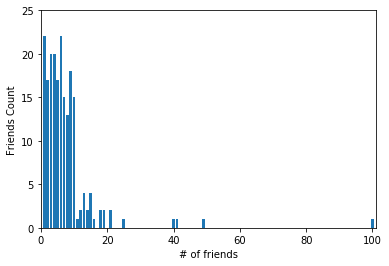

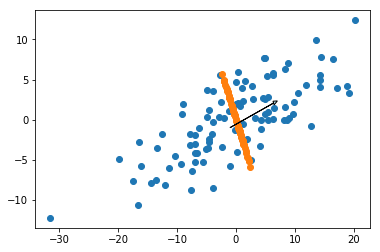

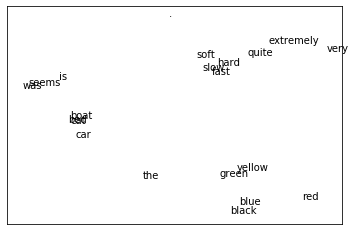

In [64]:
# Plot word vectors
    
from working_with_data import pca, transform
import matplotlib.pyplot as plt
    
# Extract the first two principal components and transform the word vectors
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)
    
# Scatter the points (and make them white so they're "invisible")
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')
    
# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])
    
# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [71]:
from deep_learning import tensor_apply, tanh

class SimpleRnn(Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.w = random_tensor(hidden_dim, input_dim, init = 'xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init = 'xavier')
        self.b = random_tensor(hidden_dim)
        
        self.reset_hidden_state()
        
    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]
        
    def forward(self, input: Tensor) -> Tensor:
        self.input = input  # Save both input and previous 
        self.prev_hidden = self.hidden # hidden state to use in backprop
        
        a = [dot(self.w[h], input) + dot(self.u[h], self.hidden) + self.b[h]
            for h in range(self.hidden_dim)]
        
        self.hidden = tensor_apply(tanh, a) # Apply tanh activation
        return self.hidden # and return the result
    
    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b has the same gradient as a
        self.b_grad = a_grad

        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]


In [82]:
from bs4 import BeautifulSoup
import requests
url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url).text, 'html5lib')

# We get the companies twice, so use a set comprehension to deduplicate.
companies = list({b.text
                      for b in soup("b")
                      if "h4" in b.get("class", ())})
assert len(companies) == 102
    
vocab = Vocabulary([c for company in companies for c in company])
    
START = "^"
STOP = "$"
    
# We need to add them to the vocabulary too.
vocab.add(START)
vocab.add(STOP)

In [83]:
vocab = Vocabulary([c for company in companies for c in company])
HIDDEN_DIM = 32  # You should experiment with different sizes!
    
rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)
    
model = Sequential([
        rnn1,
        rnn2,
        linear
    ])

In [84]:
from deep_learning import softmax
    
def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # Reset both hidden states.
    rnn2.reset_hidden_state()
    output = [seed]            # Start the output with the specified seed.
    
    # Keep going until we produce the STOP character or reach the max length
    while output[-1] != STOP and len(output) < max_len:
        # Use the last character as the input
        input = vocab.one_hot_encode(output[-1])
    
        # Generate scores using the model
        predicted = model.forward(input)
    
        # Convert them to probabilities and draw a random char_id
        probabilities = softmax(predicted)
        next_char_id = sample_from(probabilities)
    
        # Add the corresponding char to our output
        output.append(vocab.get_word(next_char_id))
    
    # Get rid of START and END characters and return the word.
    return ''.join(output[1:-1])
    
loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.9)

In [80]:
import tqdm
for epoch in range(300):
    random.shuffle(companies)  # Train in a different order each epoch.
    epoch_loss = 0             # Track the loss.
    for company in tqdm.tqdm(companies):
        rnn1.reset_hidden_state()  # Reset both hidden states.
        rnn2.reset_hidden_state()
        company = START + company + STOP   # Add START and STOP characters.
    
        # The rest is just our usual training loop, except that the inputs
        # and target are the one-hot-encoded previous and next characters.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)
    
    # Each epoch print the loss and also generate a name
    print(epoch, epoch_loss, generate())
    
    # Turn down the learning rate for the last 100 epochs.
    # There's no principled reason for this, but it seems to work.
    if epoch == 200:
        optimizer.lr *= 0.1